In [2]:
import re
import pandas as pd
import glob
import numpy as np
from Chemometrics.basic import read_mzxml,psave,pload
from mass_simple import filter0, rt_correction, match_df, result2excel,ppm,mzs
from mass_simple import avg_mass, irons
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext line_profiler

In [3]:
iron_lib_file = 'irons.p'
iron_lib_file = 'irons.p'
irons = pload(iron_lib_file)

In [4]:
allfiles = glob.glob("../data/*.mzxml")
f = allfiles[0]
f

'../data\\data010.mzXML'

In [10]:
def tw80(data_file, out_file=None, out_type='zh'):
    # 吐温80匹配操作整个流程

    # 读取并初筛、清洗数据
    df = read_mzxml(data_file)  # 读取mzxml
    # df = df.round(5) # 保留5位小数
    # df = filter0(df)  # m/z 初筛
    df = rt_correction(df)  # 保留时间校正
    # 匹配质谱库
    avg_dfs = match_df(df)
    out = avg_dfs.loc[avg_dfs.n.notnull()].sort_values(['grp', 'n'])
    # 结果输出
    if out_file:
        result2excel(out, out_file, out_type=out_type)
    return out

In [12]:
def rt_real(df, rtrange=(9.121, 11.774), mz=1331.8279, et=20*ppm, type_='max'):
    """
    实测保留时间计算
        eic最大强度处的保留时间
    """

    # 选取大范围的样本点
    df_rtrange = df.loc[df.rt.between(*rtrange)]
    mask = abs(df_rtrange.mz - mz) < mz*et
    eic = df_rtrange[mask]
    rtmz_real = eic.rt[eic['intensity'].idxmax()]
    return rtmz_real

In [13]:
df = read_mzxml(f)
rtB = 10.91  
rtB - rt_real(df)

0.0009499999999995623

In [5]:
#psave(df,'data010.p')

In [6]:
#df.to_excel('data010吐温80一级质谱库处理结果.xlsx')

In [7]:
#(['组别','聚合度（n=w+x+y+z）'，'质荷比（MS）'])
#a1 = pd.read_excel('./mike吐温80c++结果.xlsx').ffill().drop('结构式',axis=1)

In [14]:
from mass_simple import rt_real,rtB

In [15]:
df = read_mzxml(f)  # 读取mzxml
df = df.round(5) # 保留5位小数
# df = filter0(df)  # m/z 初筛
delta = rtB-rt_real(df)

In [16]:
delta

0.0009499999999995623

不初筛，匹配条数变少了？

In [17]:
from mass_simple import rts_range
categories = rts_range.index.tolist()

In [19]:
#保留时间分组
[len(df.loc[df.rt.between(*row)]) for _,row in rts_range.iterrows()]

[93247, 93247, 435413, 573968, 526913, 781205, 322134, 205462]

A：93247   
B:435413  
C:573968  
D:526913  
E:781205  
F:322134   
G:205462  

In [53]:
# 根据质荷比 在组内再次分组? 是平均质谱图？

In [54]:
[len(avg_mass(df.loc[df.rt.between(*row)])) for _,row in rts_range.iterrows()]

[8103, 8103, 8872, 10299, 9074, 10655, 8713, 7635]

In [20]:
res = tw80(f)

In [60]:
res.to_excel('finally.xls')

---
  和mike的C++结果一致

---
# 同位素匹配

In [29]:
files = glob.glob('../_TW*分子式_数值版.xlsx')
files

['..\\_TW20_分子式_数值版.xlsx',
 '..\\_TW40_分子式_数值版.xlsx',
 '..\\_TW60_分子式_数值版.xlsx',
 '..\\_TW80_分子式_数值版.xlsx',
 '..\\_TW85_分子式_数值版.xlsx']

In [33]:
dfs_ = pd.read_excel('..\\_TW80_分子式_数值版.xlsx', sheetname=None)
cat = [cat for cat in dfs_]
df = read_mzxml(f)
df = rt_correction(df)

In [62]:
def _match(mz_lib, avg, delta=20*ppm):
    """
    质荷比匹配
    """
    mz = avg.mz.values.reshape(-1, 1)
    abs_error = np.abs(mz_lib - mz)
    is_near = abs_error < mz_lib * delta
    inten_ = []
    for i in range(len(mz_lib)):
        mask = is_near[:, i]
        total_intensity = avg.intensity.loc[mask].sum()
        inten_.append(total_intensity)  
    return inten_

In [52]:
A_ = df.loc[df.rt.between(*rts_range.loc['A-1'])]
A_avg = avg_mass(A_)
mzs = dfs_[cat[0]].loc[:, dfs_[cat[0]].columns.str.startswith('m')]
mzs_ = mzs.values.reshape(-1, 1).flatten()
intes_ = np.reshape(_match(mzs_, A_avg), mzs.shape)
intens_ = pd.DataFrame(intes_, columns=mzs.columns)

In [84]:
#匹配度计算公式
def iso_matchness(isos, p):
    #匹配度计算公式
    isos = np.asarray(isos)
    p = np.asarray(p)
    #
    if isos[0] == 0:
        return None
    else:
        isos = isos/isos[0]
    w = p/p.sum()
    error = np.abs(isos - p).dot(w)
    match = (1 - error) * 100
    return match

In [159]:
def iso_match_vec(piso, p):
    w = p.values/p.sum(axis=1).values.reshape(-1, 1)
    match = (1- (np.abs(piso - p) * w).sum(axis=1).replace(0, np.nan))*100
    return match

def perspect(intens_):
    a = intens_.replace(0, np.nan)
    a = a.loc[:, a.columns.str.endswith('z1')]
    a = a.values/a.iloc[:, 0].values.reshape(-1, 1)
    a = pd.DataFrame(a).fillna(0)
    return a

In [165]:
p = dfs_[cat[0]].loc[:, dfs_[cat[0]].columns.str.startswith('p')]
piso = perspect(intens_)
matchness = iso_match_vec(piso.values, p)

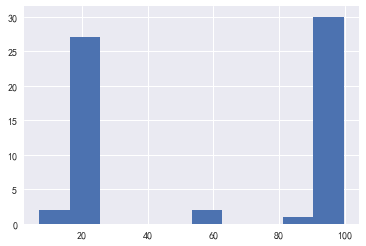

In [170]:
matchness.hist()

In [5]:
df = read_mzxml(f)

In [55]:
df.head()

,intensity,rt,mz
0,693.519653,0.042633,100.075634
1,28543.634766,0.042633,102.127897
2,1133.792358,0.042633,102.147927
3,2317.931396,0.042633,103.131099
4,302.959198,0.042633,103.142371


In [13]:
_mz = df.mz.sort_values()

In [79]:
a = df.sort_values(by=['mz','rt']).iloc[:2000]
a.tail()

,intensity,rt,mz
598508,424.747406,10.323900,102.127677
759886,3315.907715,12.017517,102.127679
372029,2739.820068,9.442067,102.127679
739596,302.292999,11.642533,102.127681
1335910,223.916672,15.742667,102.127682


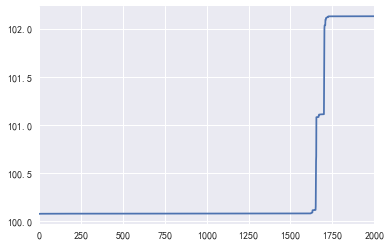

In [80]:
a.mz.reset_index(drop=True).plot()

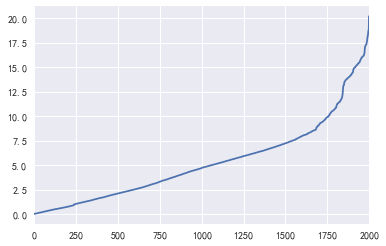

In [85]:
a.rt.sort_values().reset_index(drop=True).plot()